# imports & setup

In [28]:
import importlib
import logging
import os
from pprint import pprint

import dask
import dask.dataframe as dd
import helpers
import numpy as np
import pandas as pd
import scipy.stats
from cloudpathlib import AnyPath as Path
from helpers.pseudobulk_evaluation import deg_analysis

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
handler = logging.StreamHandler()
formatter = logging.Formatter(
    "%(asctime)s %(process)d/%(threadName)s %(name)s %(levelname)s\n%(message)s"
)
handler.setFormatter(formatter)
logging.getLogger().handlers = [handler]

In [4]:
logging.getLogger("gcsfs").setLevel("DEBUG")
logging.getLogger("google.cloud.bigquery").setLevel("DEBUG")
logging.getLogger("helpers").setLevel("DEBUG")
logging.getLogger("pandas").setLevel("DEBUG")
logging.getLogger("pyarrow").setLevel("DEBUG")

In [5]:
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")
logger.debug("test debug-level message")

2022-07-17 13:59:47,633 30524/MainThread __main__ DEBUG
test debug-level message


# loading data

## metadata

### TCGA SKCM fractions (estimated)

In [6]:
df_tcga_skcm_fractions_from_csx = helpers.datasets.load_tcga_skcm_fractions_from_csx()

2022-07-17 13:59:47,640 30524/MainThread helpers.datasets DEBUG
loading TCGA SKCM fractions estimated by CIBERSORTx
2022-07-17 13:59:47,723 30524/MainThread gcsfs.credentials DEBUG
Connected with method google_default
2022-07-17 13:59:47,726 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'downloaded_manually/derek_csx_tcga_skcm/CIBERSORTx_Job8_Results.txt'), None
2022-07-17 13:59:47,727 30524/fsspecIO gcsfs.credentials DEBUG
GCS refresh
2022-07-17 13:59:47,783 30524/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/downloaded_manually%2Fderek_csx_tcga_skcm%2FCIBERSORTx_Job8_Results.txt?alt=media, (), {'Range': 'bytes=0-86860'}


### TCGA SKCM sample types (metastatic, primary, etc)

In [7]:
from google.cloud import bigquery

bqclient = bigquery.Client()

query_string = """
SELECT * 
FROM `isb-cgc-bq.TCGA.biospecimen_gdc_current`
where project_short_name = "TCGA-SKCM"
    and sample_type_name = "Metastatic"
order by sample_barcode
"""

df_tcga_sample_metadata = (
    bqclient.query(query_string).result().to_dataframe(progress_bar_type="tqdm")
)

Downloading:   0%|          | 0/369 [00:00<?, ?rows/s]2022-07-17 13:59:49,282 30524/MainThread google.cloud.bigquery._pandas_helpers DEBUG
Started reading table 'keen-dispatch-316219._37d4cdf3349bb7a5059aac014cff35ac3e47f49a.anoncb9e35280e378cfd469a3b47dd8c4779777f6ac2' with BQ Storage API session 'projects/keen-dispatch-316219/locations/us/sessions/CAISDGs1aEY1N0p4dmZoMRoCamYaAmpk'.
Downloading: 100%|██████████| 369/369 [00:01<00:00, 315.78rows/s]


## RNA-seq TPM

### TCGA SKCM (real) bulk rna-seq

In [8]:
uri_tcga_skcm_bulk_rnaseq = (
    "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/"
    "mixtures_real_tcga_skcm/tpm.parquet"
)

In [10]:
ddf_tcga_skcm_bulk_rnaseq = dd.read_parquet(uri_tcga_skcm_bulk_rnaseq, engine="pyarrow")
logger.debug(ddf_tcga_skcm_bulk_rnaseq.dtypes)

2022-07-17 13:59:51,421 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-17 13:59:51,451 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-17 13:59:51,484 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-17 13:59:51,513 30524/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures_real_tcga_skcm%2Ftpm.parquet?alt=media, (), {'Range': 'bytes=47361643-47427178'}
2022-07-17 13:59:51,552 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-17 13:59:51,582 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liula

In [11]:
ddf_tcga_skcm_bulk_rnaseq

,gene_symbol,aliquot_barcode,tpm
npartitions=1,,,
,category[unknown],category[unknown],float64
,...,...,...


### pseudo bulk rna-seq

In [12]:
uri_pseudobulk_rnaseq = (
    "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/"
    "mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet"
)

In [14]:
ddf_pseudobulk_rnaseq = (
    dd.read_parquet(
        uri_pseudobulk_rnaseq,
        engine="pyarrow",
    )
    .replace({"malignant_from_one_sample": {"True": True, "False": False}})
    .astype({"n_cells": "uint8", "malignant_from_one_sample": "bool"})
    .rename(columns={"tcga_aliquot_barcode_for_fractions": "aliquot_barcode"})
)

logger.debug(ddf_pseudobulk_rnaseq.dtypes)

2022-07-17 13:59:53,739 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-17 13:59:53,771 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-17 13:59:53,802 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet'), None
2022-07-17 13:59:53,833 30524/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures%2Fn_cells=5%2Fmalignant_from_one_sample=True%2Fdata.parquet?alt=media, (), {'Range': 'bytes=41829238-41894773'}
2022-07-17 13:59:53,880 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtur

In [15]:
ddf_pseudobulk_rnaseq

,gene_symbol,aliquot_barcode,tpm,n_cells,malignant_from_one_sample
npartitions=1,,,,,
,category[unknown],category[unknown],float64,uint8,bool
,...,...,...,...,...


# analysis

## determine immune high and low

In [86]:
importlib.reload(helpers.pseudobulk_evaluation.deg_analysis)
df_sample_metadata = deg_analysis.make_labels_for_aliquots(
    df_tcga_skcm_fractions_from_csx, df_tcga_sample_metadata
)

In [87]:
df_sample_metadata

,sample_barcode,sample_type_name,aliquot_barcode,immune_fraction,immune_low,immune_high
0,TCGA-3N-A9WB-06A,Metastatic,TCGA-3N-A9WB-06A-11R-A38C-07,0.006247,True,False
1,TCGA-3N-A9WC-06A,Metastatic,TCGA-3N-A9WC-06A-11R-A38C-07,0.269736,False,True
2,TCGA-3N-A9WD-06A,Metastatic,TCGA-3N-A9WD-06A-11R-A38C-07,0.119879,False,False
3,TCGA-BF-AAP0-06A,Metastatic,TCGA-BF-AAP0-06A-11R-A39D-07,0.274458,False,True
4,TCGA-D3-A1Q1-06A,Metastatic,TCGA-D3-A1Q1-06A-21R-A18T-07,0.037102,False,False
...,...,...,...,...,...,...
363,TCGA-YG-AA3O-06A,Metastatic,TCGA-YG-AA3O-06A-11R-A38C-07,0.042878,False,False
364,TCGA-YG-AA3P-06A,Metastatic,TCGA-YG-AA3P-06A-11R-A38C-07,0.027623,False,False
365,TCGA-Z2-A8RT-06A,Metastatic,TCGA-Z2-A8RT-06A-11R-A37K-07,0.092170,False,False
366,TCGA-Z2-AA3S-06A,Metastatic,TCGA-Z2-AA3S-06A-11R-A39D-07,0.043985,False,False


In [88]:
df_sample_metadata[["immune_low", "immune_high"]].value_counts()

immune_low  immune_high
False       False          220
            True            74
True        False           74
dtype: int64

## more

## compute stats on real (TCGA) bulk RNA-seq

In [19]:
logging.getLogger("helpers.pseudobulk_evaluation.deg_analysis").setLevel(
    "INFO"
)  # DEBUG is loud

In [89]:
importlib.reload(helpers.pseudobulk_evaluation.deg_analysis)

<module 'helpers.pseudobulk_evaluation.deg_analysis' from '/home/jupyter/deconv/helpers/pseudobulk_evaluation/deg_analysis.py'>

In [90]:
df_gene_stats_tcga_skcm = deg_analysis.add_immune_groups_to_rnaseq(
    ddf_tcga_skcm_bulk_rnaseq, df_sample_metadata
)

df_gene_stats_pseudobulks = deg_analysis.add_immune_groups_to_rnaseq(
    ddf_pseudobulk_rnaseq, df_sample_metadata
)

2022-07-17 15:16:55,928 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('liulab', 'data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet'), None
2022-07-17 15:16:55,975 30524/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures_real_tcga_skcm%2Ftpm.parquet?alt=media, (), {'Range': 'bytes=47361643-47427178'}
2022-07-17 15:16:56,013 30524/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures_real_tcga_skcm%2Ftpm.parquet?alt=media, (), {'Range': 'bytes=4-548156'}
2022-07-17 15:16:56,056 30524/fsspecIO gcsfs DEBUG
GET: https://storage.googleapis.com/download/storage/v1/b/liulab/o/data%2Fpseudobulk_optimization%2F3_with_tcga_qc%2Fmixtures_real_tcga_skcm%2Ftpm.parquet?alt=media, (), {'Range': 'bytes=548293-47424233'}
2022-07-17 15:17:26,285 30524/fsspecIO gcsfs DEBUG
GET: b/{}/o/{}, ('l

In [80]:
df_gene_stats_adjusted = deg_analysis.process_gene_level_results(df_gene_stats)

# todo

* need to add `process_gene_level_results` to add_immune_groups_to_rnaseq, or something. 


In [72]:
# merge real and pseudo data
ddf_bulk_rnaseq_all = ddf_tcga_skcm_bulk_rnaseq.merge(
    ddf_pseudobulk_rnaseq,
    on=["aliquot_barcode", "gene_symbol"],
    how="inner",
    suffixes=["_tcga_skcm", "_pseudo"],
)

In [ ]:
ddf_bulk_rnaseq_all

In [ ]:
ddf_bulk_rnaseq_all_with_immune = ddf_bulk_rnaseq_all.merge(
    df_immune_fraction_by_aliquot_barcode,
    left_on="aliquot_barcode",
    right_on="sample_id",
)

ddf_bulk_rnaseq_all_with_immune

In [ ]:
# compute immune high and low
immune_threshold_low = ddf_bulk_rnaseq_all_with_immune["immune_fraction"].quantile(0.2)
immune_threshold_high = ddf_bulk_rnaseq_all_with_immune["immune_fraction"].quantile(0.8)

In [ ]:
immune_threshold_low, immune_threshold_high

In [ ]:
ddf_bulk_rnaseq_all_with_immune["immune_low"] = (
    ddf_bulk_rnaseq_all_with_immune["immune_fraction"] <= immune_threshold_low
)

ddf_bulk_rnaseq_all_with_immune["immune_high"] = (
    ddf_bulk_rnaseq_all_with_immune["immune_fraction"] >= immune_threshold_high
)

In [ ]:
df_bulk_rnaseq_all_with_immune = ddf_bulk_rnaseq_all_with_immune.compute()

In [ ]:
df_bulk_rnaseq_all_with_immune["aliquot_barcode"].value_counts()

In [ ]:
df_bulk_rnaseq_all_with_immune[["immune_low", "immune_high"]].value_counts()

#### compute stats for each gene

In [ ]:
### compute p-values...


def compute_stats(df):
    immune_low = df[df["immune_low"]]
    immune_high = df[df["immune_high"]]
    pval_pseudo = scipy.stats.mannwhitneyu(
        immune_high["tpm_pseudo"].values, immune_low["tpm_pseudo"].values
    )[1]
    neglog10pval_pseudo = -np.log10(pval_pseudo)
    foldchange_pseudo = (
        immune_high["tpm_pseudo"].mean() / immune_low["tpm_pseudo"].mean()
    )
    log2foldchange_pseudo = np.log2(foldchange_pseudo)

    pval_real = scipy.stats.mannwhitneyu(
        immune_high["tpm_tcga_skcm"].values, immune_low["tpm_tcga_skcm"].values
    )[1]
    neglog10pval_real = -np.log10(pval_real)
    foldchange_real = (
        immune_high["tpm_tcga_skcm"].mean() / immune_low["tpm_tcga_skcm"].mean()
    )
    log2foldchange_real = np.log2(foldchange_real)

    return pd.Series(
        dict(
            pval_pseudo=pval_pseudo,
            foldchange_pseudo=foldchange_pseudo,
            log2foldchange_pseudo=log2foldchange_pseudo,
            neglog10pval_pseudo=neglog10pval_pseudo,
            signedneglog10pval_pseudo=(
                neglog10pval_pseudo * np.sign(log2foldchange_pseudo)
            ),
            pval_real=pval_real,
            foldchange_real=foldchange_real,
            log2foldchange_real=log2foldchange_real,
            neglog10pval_real=neglog10pval_real,
            signedneglog10pval_real=(neglog10pval_real * np.sign(log2foldchange_real)),
        )
    )


df_gene_stats_by_immune = df_bulk_rnaseq_all_with_immune.groupby("gene_symbol").apply(
    compute_stats
)
df_gene_stats_by_immune = df_gene_stats_by_immune.reset_index()

In [ ]:
df_gene_stats_by_immune

In [ ]:
# how many genes have valid stats?

logger.debug(df_gene_stats_by_immune["pval_pseudo"].isna().value_counts())
logger.debug(df_gene_stats_by_immune["foldchange_pseudo"].isna().value_counts())
logger.debug(df_gene_stats_by_immune["pval_real"].isna().value_counts())
logger.debug(df_gene_stats_by_immune["foldchange_real"].isna().value_counts())

# plots

In [82]:
import plotly.express as px

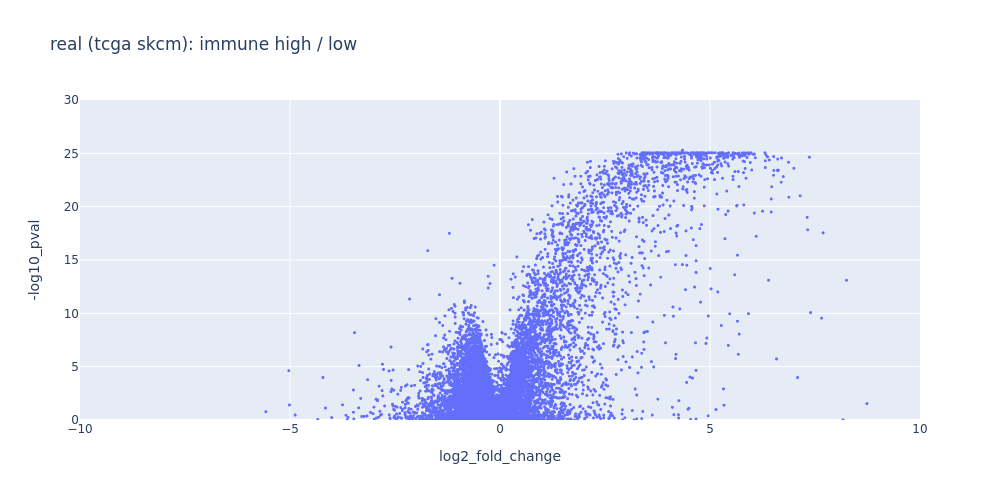

In [83]:
fig = px.scatter(
    df_gene_stats_adjusted,
    x="log2_fold_change",
    y="-log10_pval",
    title="real (tcga skcm): immune high / low",
    hover_name="gene_symbol",
    hover_data=["fold_change", "pval"],
)
fig.update_xaxes(range=(-10, 10))
fig.update_yaxes(range=(0, 30))
fig.update_traces(marker=dict(size=3))
fig.show(renderer="png", scale=1, width=1000, height=500)

In [ ]:
fig = px.scatter(
    df_gene_stats_adjusted,
    x="log2_fold_change",
    y="-log10_pval",
    title="pseudobulk RNA-seq: immune high / low",
    hover_name="gene_symbol",
    hover_data=["fold_change", "pval"],
)
fig.update_xaxes(range=(-10, 10))
fig.update_yaxes(range=(0, 30))
fig.update_traces(marker=dict(size=3))
fig.show(renderer="png", scale=1, width=1000, height=500)

In [ ]:
fig.show(renderer="browser")

In [ ]:
fig = px.scatter(
    df_gene_stats_adjusted,
    x="log2foldchange_pseudo",
    y="neglog10pval_pseudo",
    title="pseudobulks: immune high / low",
    hover_name="gene_symbol",
    hover_data=["foldchange_pseudo", "pval_pseudo"],
)
fig.update_xaxes(range=(-10, 10))
fig.update_yaxes(range=(0, 30))
fig.update_traces(marker=dict(size=3))
fig.show(renderer="png", scale=2, width=800, height=600)

In [ ]:
fig.show(renderer="browser")

In [ ]:
fig = px.scatter(
    df_gene_stats_by_immune,
    x="signedneglog10pval_real",
    y="signedneglog10pval_pseudo",
    trendline="ols",
    title="signed -log10(p-values): pseudobulks vs tcga skcm",
    hover_name="gene_symbol",
    hover_data=["log2foldchange_real", "log2foldchange_pseudo"],
)
fig.update_xaxes(range=(-25, 25))
fig.update_yaxes(range=(-25, 25))
fig.update_traces(marker=dict(size=3))
fig.show(renderer="png", scale=1, width=500, height=500)

In [ ]:
fig.show(renderer="browser")

In [ ]:
df_gene_stats_by_immune.info()

In [ ]:
fig = px.scatter(
    df_gene_stats_by_immune,
    x="log2foldchange_real",
    y="log2foldchange_pseudo",
    trendline="ols",
    title="logs(fold-change): pseudobulks vs tcga skcm",
    hover_name="gene_symbol",
    # hover_data=["log2foldchange_real", "log2foldchange_pseudo"],
)
# fig.update_xaxes(range=(-25, 25))
# fig.update_yaxes(range=(-25, 25))
fig.update_traces(marker=dict(size=3))
fig.show(renderer="png", scale=1, width=500, height=500)
fig.show(renderer="browser")

In [ ]:
fig.show(renderer="browser")

#### what's the overlap for significant genes between real, pseudo?

In [ ]:
df_gene_stats_by_immune["percentile_neglog10pval_pseudo"] = df_gene_stats_by_immune[
    "neglog10pval_pseudo"
].rank(pct=True)
df_gene_stats_by_immune["percentile_neglog10pval_real"] = df_gene_stats_by_immune[
    "neglog10pval_real"
].rank(pct=True)

In [ ]:
THRESHOLD = 0.9

df_gene_stats_by_immune["top_pseudo"] = (
    df_gene_stats_by_immune["percentile_neglog10pval_pseudo"] > THRESHOLD
)
df_gene_stats_by_immune["top_real"] = (
    df_gene_stats_by_immune["percentile_neglog10pval_real"] > THRESHOLD
)
df_gene_stats_by_immune["top_both"] = (
    df_gene_stats_by_immune["top_pseudo"] & df_gene_stats_by_immune["top_real"]
)
pd.crosstab(df_gene_stats_by_immune["top_pseudo"], df_gene_stats_by_immune["top_real"])

In [ ]:
# TODO - a good summary stat here would be the odds ratio of this contingency table

In [ ]:
# TODO - benjamini hochberg for a FDR-corrected significance test (use FDR of 0.1)

In [ ]:
# TODO - also do scatter for fold change

In [ ]:
# is it the same genes that showed up in the PCA analysis?